In [24]:
# TODO
# Dodać tytuł, treść zadania, autorów itp
# Opisać uzyskane wyniki
# Więcej metryk (?)
# pdf z dokumentacja (?)


In [25]:
from tree import DecisionTreeClassifier
from forest import RandomForestClassifier

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier

from copy import deepcopy

import seaborn as sns


#### Funkcje pomocnicze

In [26]:
"""
Przygotowanie, obróbka danych
"""

def prepare_data() -> tuple():
    df = pd.read_csv('data.csv')

    # Kolumna mówiąca o id nie powinna mieć wpływu na przeżywalność, tak samo jak imię i nazwisko
    df.drop(columns=['PassengerId', 'Name'], inplace=True)

    # Spróbujemy w jakiś sposób wykorzystać informacje o kabinie
    df['CabinFirst'] = df.Cabin.apply(lambda x: str(x)[0])
    df['CabinCenter'] = df.Cabin.apply(lambda x: str(x)[2])
    df['CabinLast'] = df.Cabin.apply(lambda x: str(x)[-1])

    df.drop(columns=['Cabin'], inplace=True)   

    # Kodowanie wartości kategorycznych
    df = pd.get_dummies(df, columns=['HomePlanet', 'CabinFirst', 'CabinCenter', 'CabinLast', 'Destination'])

    # Podział na zbiory testowe i treningowe
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['Transported']),
        df['Transported'].astype(int),
        test_size=0.3,
        random_state=42
    )

    # Uzupełnienie brakujących wartości
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_m_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    num_columns = X_train.select_dtypes(include=['float64']).columns
    obj_columns = X_train.select_dtypes(include=['object']).columns

    X_train[num_columns] = imp_median.fit_transform(X_train[num_columns])
    X_train[obj_columns] = imp_m_freq.fit_transform(X_train[obj_columns])

    X_test[num_columns] = imp_median.transform(X_test[num_columns])
    X_test[obj_columns] = imp_m_freq.transform(X_test[obj_columns])

    # Wartości boolowskie należy zamienić na inty
    X_train[['CryoSleep', 'VIP']] = X_train[['CryoSleep', 'VIP']].fillna(0).astype(int)
    X_test[['CryoSleep', 'VIP']] = X_test[['CryoSleep', 'VIP']].fillna(0).astype(int)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    return X_train, X_test, y_train, y_test


In [27]:
"""
Własna funkcja do walidacji krzyżowej.
Nasz model nie spełnia wymagań do zastosowania tej z sklearn.
"""

def cross_validation(model, X: np.array, y: np.array, cv: int = 5) -> float:
    n_samples = len(X)
    fold_size = n_samples // cv
    indices = np.random.permutation(n_samples)

    scores = []

    for i in range(cv):
        model_ = deepcopy(model)

        validation_indices = indices[i * fold_size : (i+1) * fold_size]
        train_indices = np.concatenate((indices[:i * fold_size], indices[(i+1) * fold_size:]))

        X_train = X[train_indices]
        y_train = y[train_indices]
        X_val = X[validation_indices]
        y_val = y[validation_indices]

        model_.fit(X_train, y_train)
        preds = model_.predict(X_val)
        score = accuracy_score(y_val, preds)
        scores.append(score)

    return np.mean(scores)


In [28]:
"""
Generowanie wyników walidacji krzyżowej dla zadanych parametrów drzewa.
"""

def get_tree_cv_results(depths: list[int], min_samples: list[int], X_train: pd.DataFrame,
                        y_train: pd.DataFrame, cv: int = 5, our: bool = True) -> pd.DataFrame:
    scores= []

    for depth in depths:
        tmp_scores = []
        
        for samples in min_samples:
            if our:
                model = DecisionTreeClassifier(max_depth=depth, min_samples_split=samples)
            else:
                model = SklearnDecisionTreeClassifier(max_depth=depth, min_samples_split=samples, criterion='entropy')
            tmp_scores.append(cross_validation(model, X_train.to_numpy(), y_train.to_numpy(), cv=cv))

        scores.append(tmp_scores)

    return pd.DataFrame(scores, index=depths, columns=min_samples)


In [29]:
"""
Generowanie wyników walidacji krzyżowej dla zadanych parametrów lasu.
"""

def get_forest_cv_results(depths: list[int], n_estimators: list[int], X_train: pd.DataFrame,
                        y_train: pd.DataFrame, cv: int = 5, our: bool = True) -> pd.DataFrame:
    scores= []

    for depth in depths:
        tmp_scores = []
        
        for estimators in n_estimators:
            if our:
                model = RandomForestClassifier(max_depth=depth, n_estimators=estimators)
            else:
                model = SklearnRandomForestClassifier(max_depth=depth, n_estimators=estimators, criterion='entropy')
            score = cross_validation(model, X_train.to_numpy(), y_train.to_numpy(), cv=cv)
            tmp_scores.append(score)
        
        scores.append(tmp_scores)

    return pd.DataFrame(scores, index=depths, columns=n_estimators)


#### Porównanie wyników


In [31]:
DEPTHS = [3, 5, 8, 13, 21]
MIN_SAMPLES = [2, 3, 5, 8, 13]

X_train, X_test, y_train, y_test = prepare_data()

res_tree_our = get_tree_cv_results(DEPTHS, MIN_SAMPLES, X_train, y_train)
res_tree_skl = get_tree_cv_results(DEPTHS, MIN_SAMPLES, X_train, y_train, our=False)


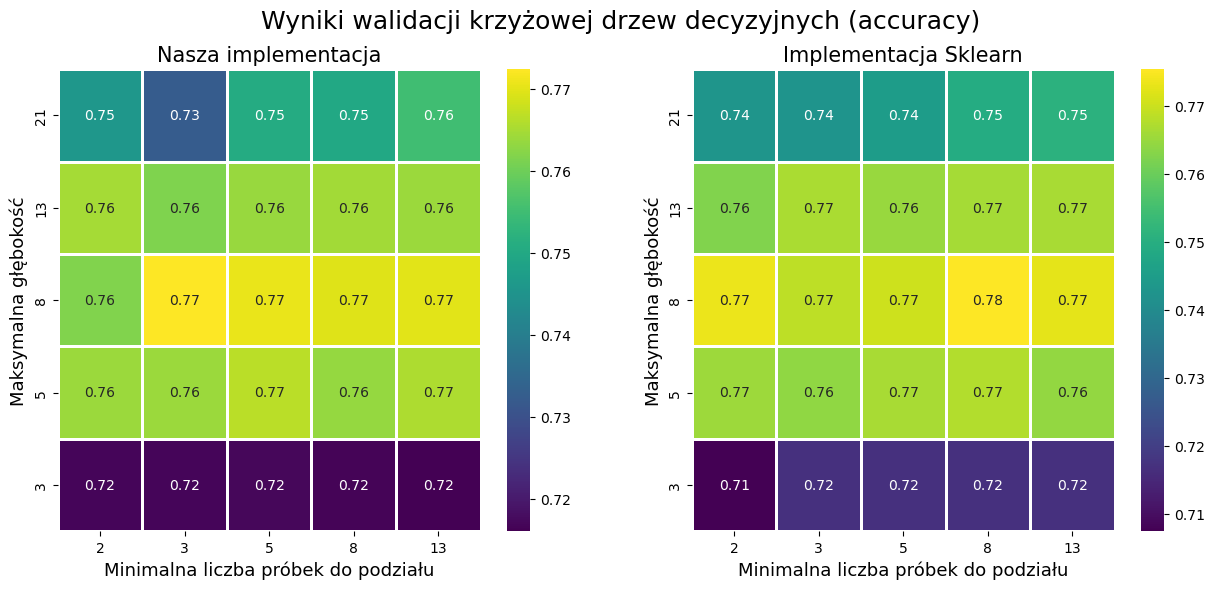

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

sns.heatmap(res_tree_our[::-1], cmap='viridis', annot=True, linewidths=2, ax=axs[0])
sns.heatmap(res_tree_skl[::-1], cmap='viridis', annot=True, linewidths=2, ax=axs[1])

axs[0].set_title("Nasza implementacja", fontsize=15)
axs[1].set_title("Implementacja Sklearn", fontsize=15)

for ax in range(2):
    axs[ax].set_xlabel("Minimalna liczba próbek do podziału", fontsize=13)
    axs[ax].set_ylabel("Maksymalna głębokość", fontsize=13)

fig.suptitle('Wyniki walidacji krzyżowej drzew decyzyjnych (accuracy)', fontsize=18)

plt.show()


In [33]:
DEPTHS = [2, 3, 5, 8, 13]
N_ESTIMATORS = [2, 3, 5, 8, 13]

X_train, X_test, y_train, y_test = prepare_data()

res_forest_our = get_forest_cv_results(DEPTHS, N_ESTIMATORS, X_train, y_train, cv=4)
res_forest_skl = get_forest_cv_results(DEPTHS, N_ESTIMATORS, X_train, y_train, cv=4, our=False)


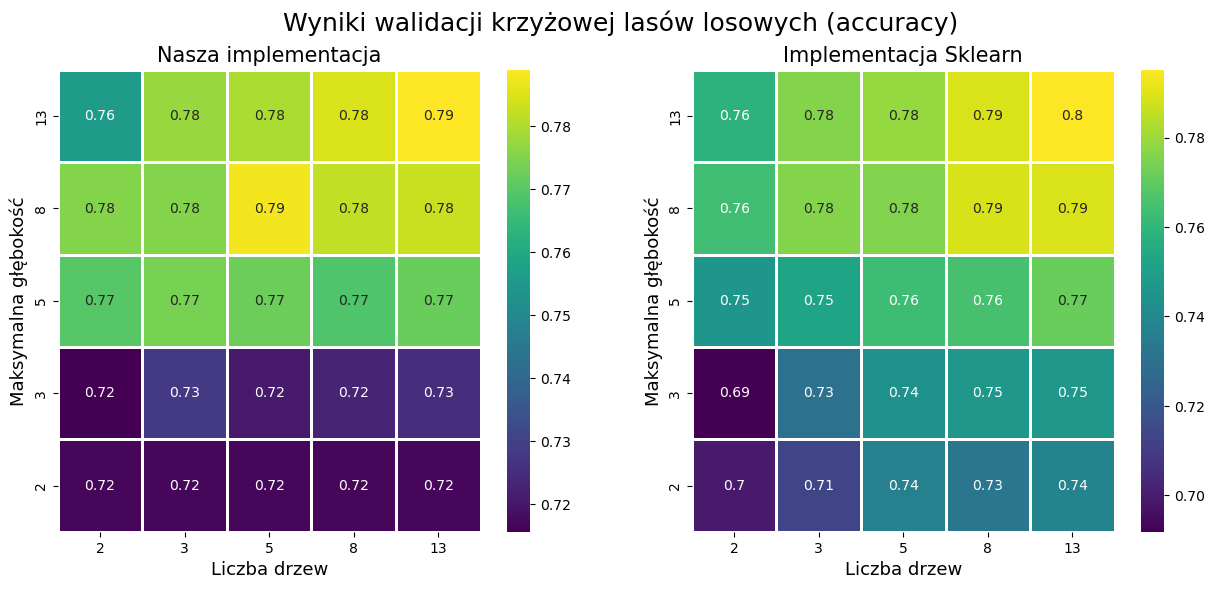

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

sns.heatmap(res_forest_our[::-1], cmap='viridis', annot=True, linewidths=2, ax=axs[0])
sns.heatmap(res_forest_skl[::-1], cmap='viridis', annot=True, linewidths=2, ax=axs[1])

axs[0].set_title("Nasza implementacja", fontsize=15)
axs[1].set_title("Implementacja Sklearn", fontsize=15)

for ax in range(2):
    axs[ax].set_xlabel("Liczba drzew", fontsize=13)
    axs[ax].set_ylabel("Maksymalna głębokość", fontsize=13)

fig.suptitle('Wyniki walidacji krzyżowej lasów losowych (accuracy)', fontsize=18)

plt.show()


In [61]:
best_our = RandomForestClassifier(max_depth=13, n_estimators=13)
best_our.fit(X_train.to_numpy(), y_train.to_numpy())
pred_our_train = best_our.predict(X_train.to_numpy())
pred_our_test = best_our.predict(X_test.to_numpy())

best_skl = SklearnRandomForestClassifier(max_depth=13, n_estimators=13, criterion='entropy')
best_skl.fit(X_train.to_numpy(), y_train.to_numpy())
pred_skl_train = best_skl.predict(X_train.to_numpy())
pred_skl_test = best_skl.predict(X_test.to_numpy())


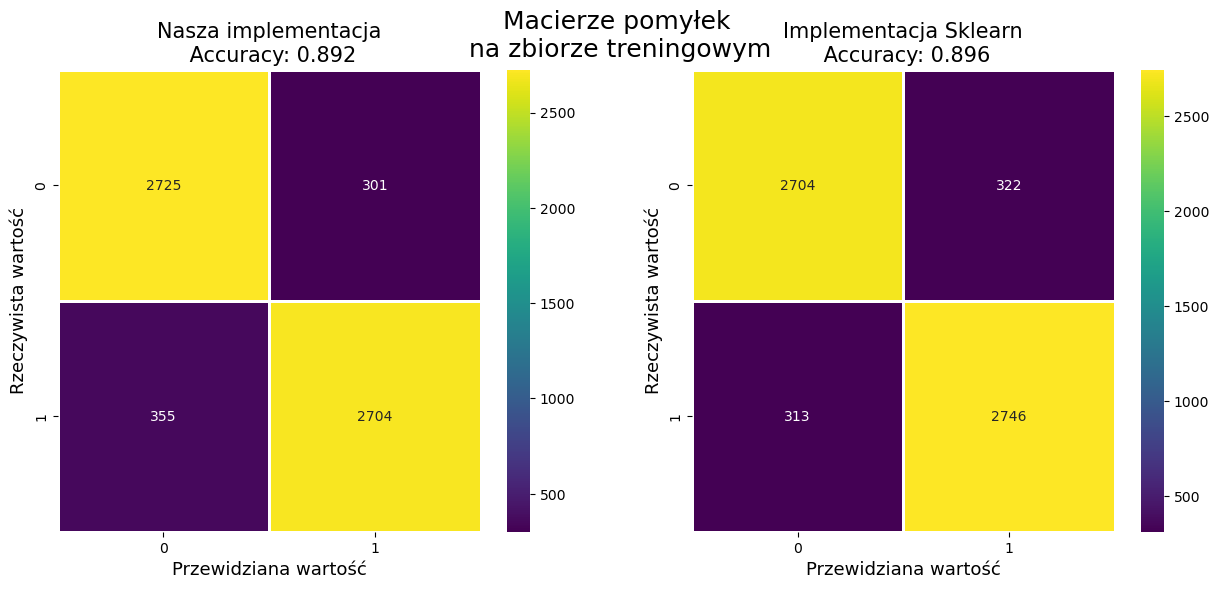

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

conf_our = confusion_matrix(y_train, pred_our_train)
conf_skl = confusion_matrix(y_train, pred_skl_train)

sns.heatmap(conf_our, cmap='viridis', annot=True, fmt='d', linewidths=2, ax=axs[0])
sns.heatmap(conf_skl, cmap='viridis', annot=True, fmt='d', linewidths=2, ax=axs[1])

axs[0].set_title(f"Nasza implementacja\n Accuracy: {round(accuracy_score(y_train, pred_our_train), 3)}", fontsize=15)
axs[1].set_title(f"Implementacja Sklearn\n Accuracy: {round(accuracy_score(y_train, pred_skl_train), 3)}", fontsize=15)

for ax in range(2):
    axs[ax].set_xlabel("Przewidziana wartość", fontsize=13)
    axs[ax].set_ylabel("Rzeczywista wartość", fontsize=13)

fig.suptitle('Macierze pomyłek \nna zbiorze treningowym', fontsize=18)

plt.show()


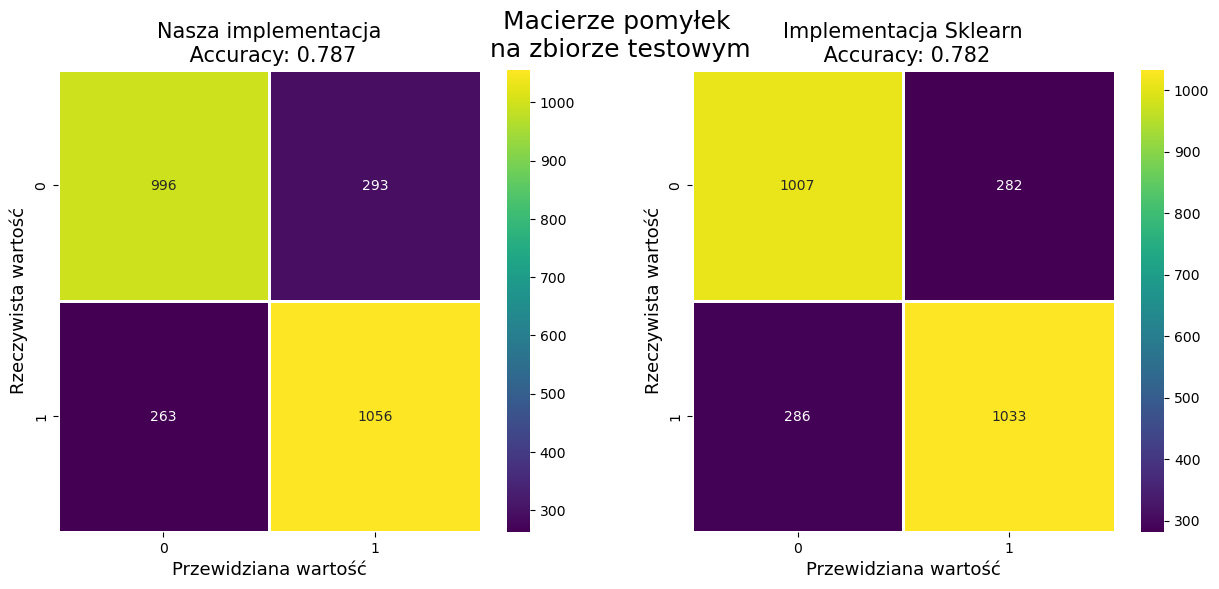

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

conf_our = confusion_matrix(y_test, pred_our_test)
conf_skl = confusion_matrix(y_test, pred_skl_test)

sns.heatmap(conf_our, cmap='viridis', annot=True, fmt='d', linewidths=2, ax=axs[0])
sns.heatmap(conf_skl, cmap='viridis', annot=True, fmt='d', linewidths=2, ax=axs[1])

axs[0].set_title(f"Nasza implementacja\n Accuracy: {round(accuracy_score(y_test, pred_our_test), 3)}", fontsize=15)
axs[1].set_title(f"Implementacja Sklearn\n Accuracy: {round(accuracy_score(y_test, pred_skl_test), 3)}", fontsize=15)

for ax in range(2):
    axs[ax].set_xlabel("Przewidziana wartość", fontsize=13)
    axs[ax].set_ylabel("Rzeczywista wartość", fontsize=13)

fig.suptitle('Macierze pomyłek \nna zbiorze testowym', fontsize=18)

plt.show()


In [67]:
# TODO
# Wnioski:
#   - Nasz działa wolniej
#   - Oba modele się przeuczają
#   - Rozwiązanie: ograniczyć liczbę kolumn / głębokość drzewa
#   - Wykresy zależności acc test/train w zależności od głębokości drzewa
#